In [1]:
import numpy as np
import h5py
from dask import array as da
import matplotlib.pyplot as plt
import seaborn as sns
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
from pathlib import Path
import os
import sys
%matplotlib inline

In [3]:
PLOTS_DIR = Path("plots")

In [4]:
# Turns out it was better to store the results in a hdf5 file
# predictions = np.load("predictions.npy")

# with h5py.File("predictions.hdf5", "w") as f:
#     dset = f.create_dataset("predictions", predictions.shape, predictions.dtype)
#     dset[:, :] = predictions

In [5]:
# The following only makes sense as shell script
try:
    print(sys.argv)
    chunksize = int(sys.argv[1])
    sample_size = -1
    print(f"Found chunksize of {chunksize}")
except Exception:
    print("No chunksize found")
    chunksize = 1000
    sample_size = 1000

['/home/dsmits/.cache/pypoetry/virtualenvs/aiproteomics-MPvhd94L-py3.10/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/dsmits/.local/share/jupyter/runtime/kernel-6b4830cc-49f1-48d8-ad85-32972e80d925.json']
No chunksize found


In [6]:
def load_dask_array_from_hdf5(filename, key, chunksize=1000, sample_size=-1):
    f = h5py.File(filename)
    a = da.from_array(f[key], chunks=chunksize)
    a = a[:sample_size]
    return a

In [7]:
predictions = load_dask_array_from_hdf5("predictions.hdf5", "predictions", chunksize, sample_size)
labels = load_dask_array_from_hdf5("traintest_hcd.hdf5", "intensities_raw", chunksize, sample_size)
collision_energy = load_dask_array_from_hdf5("traintest_hcd.hdf5", "collision_energy", chunksize, sample_size)
precursor_charge = load_dask_array_from_hdf5("traintest_hcd.hdf5", "precursor_charge_onehot", chunksize, sample_size)
sequences = load_dask_array_from_hdf5("traintest_hcd.hdf5", "sequence_integer", chunksize, sample_size)

In [8]:
full_sequences = sequences[:,-1] > 0

full_sequences.shape

(1000,)

In [9]:
sequence_lengths= da.argmin(sequences, axis=1)

In [10]:
sequence_lengths[full_sequences] = 29

In [11]:
f = h5py.File("traintest_hcd.hdf5")

f.keys()

<KeysViewHDF5 ['collision_energy', 'collision_energy_aligned', 'collision_energy_aligned_normed', 'intensities_raw', 'masses_pred', 'masses_raw', 'method', 'precursor_charge_onehot', 'rawfile', 'reverse', 'scan_number', 'score', 'sequence_integer', 'sequence_onehot']>

In [12]:
["collision_energy_aligned_normed", "precursor_charge_onehot", "sequence_integer"]

['collision_energy_aligned_normed',
 'precursor_charge_onehot',
 'sequence_integer']

In [13]:
labels.shape

(1000, 174)

In [14]:
predictions.shape

(1000, 174)

In [15]:
labels[0].compute()

array([ 0.03333019,  0.        ,  0.        ,  0.00833965,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.39771285,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.12638215,  0.        ,  0.        ,  0.00881359,  0.        ,
        0.        ,  0.0085394 ,  0.        ,  0.        ,  0.02134586,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01633287,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.01483933,  0.        ,  0.02334369,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00457667,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00765157,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.02404616,  0.        ,  0.  

In [16]:
from sklearn.preprocessing import normalize


# TODO: Check if results are the same as with ComparisonPrositFrag
def normalized_spectral_contrast_distance(true, pred):
    """
    Calculate the (normalized) spectral contrast distance for two spectra. 1 represents total overlap.
    """
    pred_norm = normalize(pred)
    true_norm = normalize(true)
    
    product =  pred_norm * true_norm
    product = product.sum(axis=1)
    
    arccos = np.arccos(product)
    return 1 - 2 * arccos / np.pi



In [17]:
normalized_spectral_contrast_distance(labels[:2], predictions[:2])

/home/dsmits/.cache/pypoetry/virtualenvs/aiproteomics-MPvhd94L-py3.10/lib/python3.10/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/dsmits/.cache/pypoetry/virtualenvs/aiproteomics-MPvhd94L-py3.10/lib/python3.10/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


array([ 0.06520899, -0.05064844])

In [18]:
limit=None

comparisons = da.map_blocks(normalized_spectral_contrast_distance, labels[:limit], predictions[:limit], drop_axis=1, dtype=float)

comparisons

dask.array<normalized_spectral_contrast_distance, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [19]:
computation, edges = da.histogram(comparisons, bins=50, range=(0, 1))

with ProgressBar():
    hist = computation.compute()

[########################################] | 100% Completed | 101.41 ms


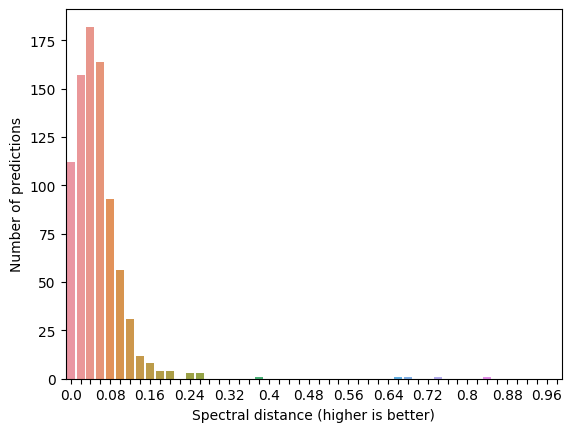

In [20]:


ax = sns.barplot(x=edges[:-1], y=hist)

_=ax.set_xticks(ticks = range(len(edges[:-1])), labels=[e if i%4 == 0 else "" for i, e in enumerate(edges[:-1])])
_ = ax.set_xlabel("Spectral distance (higher is better)")
_ = ax.set_ylabel("Number of predictions")

plt.savefig(PLOTS_DIR/"accuracy_hist.png")

In [21]:
sequence_column_names = [f"seq_{i}" for i in range(sequences.shape[1])]

sequence_df = dd.from_dask_array(sequences, columns=sequence_column_names)

concatenated = dd.concat([dd.from_dask_array(sequence_lengths), dd.from_dask_array(collision_energy), dd.from_dask_array(comparisons), sequence_df], 1)
concatenated.columns = ["sequence_length", "collision_energy", "distance"] + sequence_column_names

concatenated

,sequence_length,collision_energy,distance,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,seq_7,seq_8,seq_9,seq_10,seq_11,seq_12,seq_13,seq_14,seq_15,seq_16,seq_17,seq_18,seq_19,seq_20,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
999,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [22]:
concatenated.head()

,sequence_length,collision_energy,distance,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,...,seq_20,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29
0,19,30.0,0.065209,19,4,18,20,13,18,12,...,0,0,0,0,0,0,0,0,0,0
1,12,20.0,-0.050648,10,13,12,5,10,4,10,...,0,0,0,0,0,0,0,0,0,0
2,13,35.0,0.055116,3,1,3,18,14,12,5,...,0,0,0,0,0,0,0,0,0,0
3,11,23.0,0.058689,3,10,10,14,10,6,6,...,0,0,0,0,0,0,0,0,0,0
4,12,25.0,0.085183,4,4,6,20,3,16,18,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Let's take a sample to quickly try out analyses
sample_size= 100000
sample = concatenated.head(sample_size)

In [24]:
collision_energy[:3].compute()

array([[30.],
       [20.],
       [35.]])

In [25]:
corr_columns = ["sequence_length", "collision_energy", "distance"]

with ProgressBar():
    sample = concatenated[corr_columns].head(100000)
    correlations = sample.corr()
    
correlations

[########################################] | 100% Completed | 101.53 ms


,sequence_length,collision_energy,distance
sequence_length,1.000000,0.017732,0.654690
collision_energy,0.017732,1.000000,0.046424
distance,0.654690,0.046424,1.000000


[########################################] | 100% Completed | 102.14 ms


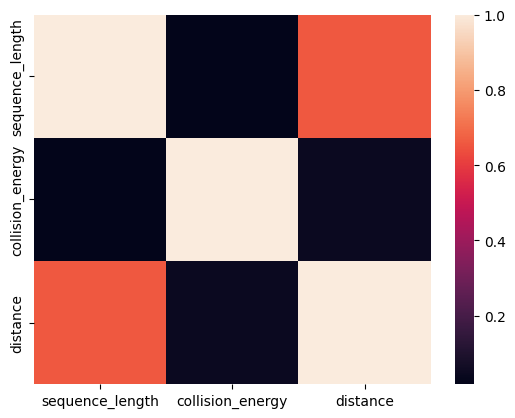

In [26]:
with ProgressBar():
    full_set_correlations = concatenated[corr_columns].corr().compute()

sns.heatmap(full_set_correlations)

plt.savefig(PLOTS_DIR/"correlations")

It seems that sequence length and distance have some correlation. I can imagine that longer sequences are more easy to predict because there is more info there? Or maybe there are unique sequences that are memorized. I wonder what the distribution is of sequence length.

<Axes: >

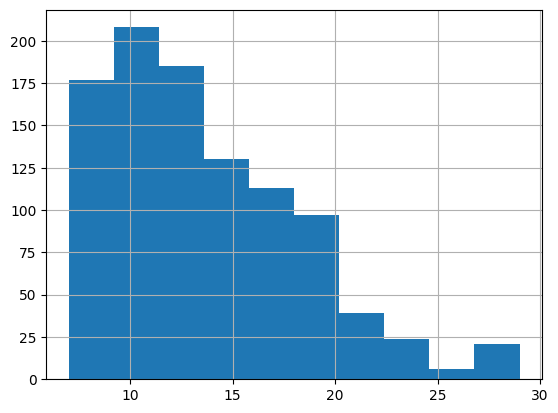

In [27]:
sample.sequence_length.hist()

In [28]:
# On the full set

freq, bins = da.histogram(concatenated["sequence_length"], bins=range(30))

with ProgressBar():
    freq = freq.compute()
    
bins = bins.compute()

[########################################] | 100% Completed | 102.15 ms


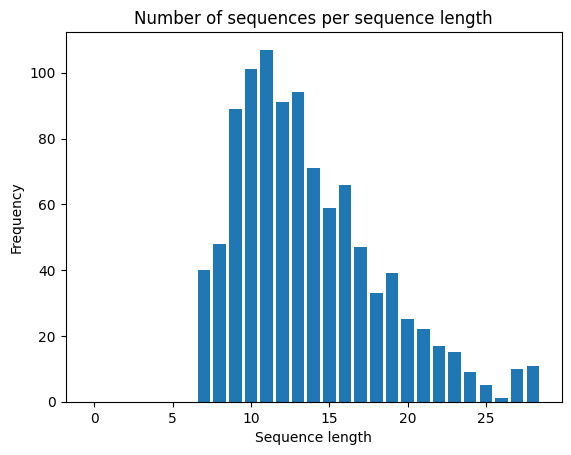

In [29]:
fig, ax = plt.subplots()

ax.bar(x=range(freq.shape[0]), height= freq)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Frequency")

ax.set_title("Number of sequences per sequence length")

plt.savefig(PLOTS_DIR/"sequence_length_histogram.png")

I wonder if there are any duplicates and whether it is possible that the model overfits on them.

In [30]:
counts = sequence_df.groupby(sequence_df.columns.tolist()).size()


counts[counts["size"] > 1]

with ProgressBar():
    counts =  counts.compute()



[########################################] | 100% Completed | 102.43 ms


Looks like there is one sequence that is in the dataset 2843 times! I wonder how that affects the training set. I also wonder if this sequence has consistent target values.

In [31]:
sorted_duplicates = counts.sort_values(ascending=False)

pd.DataFrame(sorted_duplicates, columns=["number_of_duplicates"])

number_of_duplicates
seq_0 seq_1 seq_2 seq_3 seq_4 seq_5 seq_6 seq_7 seq_8 seq_9 seq_10 seq_11 seq_12 seq_13 seq_14 seq_15 seq_16 seq_17 seq_18 seq_19 seq_20 seq_21 seq_22 seq_23 seq_24 seq_25 seq_26 seq_27 seq_28 seq_29                      
7     19    20    8     17    17    6     13    18    15    4      9      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          2
10    10    16    18    6     15    1     3     10    1     9      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          2
14    1     3     7     10    6     16    14    1     5     20     13     6      15     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
      7     16    13    6     16    1     3     16    10    16     12     3      16     14     15     0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
      6     17    6     19    12    10    18    9     16    0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
...                                                                                                                                                                                                                       ...
7     16    12    10    10    20    18    12    18    8     6      10     1      3      3      16     18     15     0      0      0      0      0      0      0      0      0      0      0      0                          1
            16    14    8     4     6     18    15    0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
      17    5     20    6     8     4     16    7     15    0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
      18    1     17    16    16    6     10    20    10    14     12     8      17     14     15     0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
21    18    18    3     5     2     15    0     0     0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1

[998 rows x 1 columns]

In [32]:
with ProgressBar():
    all_duplicates = concatenated[(concatenated[sequence_column_names] == sorted_duplicates.index[0]).all(axis=1)].compute()

all_duplicates

all_duplicates.to_csv(PLOTS_DIR/"duplicates.csv")

[########################################] | 100% Completed | 101.62 ms


## Distinguishing samples that perform well or badly



In [33]:
concatenated.head()

,sequence_length,collision_energy,distance,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,...,seq_20,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29
0,19,30.0,0.065209,19,4,18,20,13,18,12,...,0,0,0,0,0,0,0,0,0,0
1,12,20.0,-0.050648,10,13,12,5,10,4,10,...,0,0,0,0,0,0,0,0,0,0
2,13,35.0,0.055116,3,1,3,18,14,12,5,...,0,0,0,0,0,0,0,0,0,0
3,11,23.0,0.058689,3,10,10,14,10,6,6,...,0,0,0,0,0,0,0,0,0,0
4,12,25.0,0.085183,4,4,6,20,3,16,18,...,0,0,0,0,0,0,0,0,0,0


In [34]:
with ProgressBar():
    best_performing = concatenated.sort_values("distance", ascending=False).head(1000)

best_performing

[########################################] | 100% Completed | 101.94 ms


,sequence_length,collision_energy,distance,seq_0,seq_1,seq_2,seq_3,seq_4,seq_5,seq_6,...,seq_20,seq_21,seq_22,seq_23,seq_24,seq_25,seq_26,seq_27,seq_28,seq_29
635,29,35.0,0.845350,11,11,14,14,13,15,18,...,1,18,13,19,16,1,19,18,17,15
236,29,25.0,0.745997,6,4,2,16,13,13,6,...,10,16,13,20,13,2,13,1,13,9
769,29,28.0,0.693593,11,1,3,7,10,11,10,...,1,1,1,7,6,13,7,1,10,15
775,29,35.0,0.671265,10,8,7,16,6,16,16,...,13,20,17,6,10,9,1,3,12,15
948,29,35.0,0.393569,1,12,10,1,10,13,14,...,16,13,14,4,18,16,16,6,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,7,28.0,-0.119843,9,13,3,3,8,13,15,...,0,0,0,0,0,0,0,0,0,0
316,11,35.0,-0.128245,20,13,4,9,4,16,4,...,0,0,0,0,0,0,0,0,0,0
962,13,25.0,-0.141196,8,6,17,6,16,5,6,...,0,0,0,0,0,0,0,0,0,0
115,13,23.0,-0.148923,20,13,4,11,3,10,3,...,0,0,0,0,0,0,0,0,0,0


In [35]:
best_performing.iloc[0]

sequence_length     29.00000
collision_energy    35.00000
distance             0.84535
seq_0               11.00000
seq_1               11.00000
seq_2               14.00000
seq_3               14.00000
seq_4               13.00000
seq_5               15.00000
seq_6               18.00000
seq_7                4.00000
seq_8               17.00000
seq_9                3.00000
seq_10              17.00000
seq_11               8.00000
seq_12               6.00000
seq_13               1.00000
seq_14               6.00000
seq_15               4.00000
seq_16               6.00000
seq_17              13.00000
seq_18              14.00000
seq_19              14.00000
seq_20               1.00000
seq_21              18.00000
seq_22              13.00000
seq_23              19.00000
seq_24              16.00000
seq_25               1.00000
seq_26              19.00000
seq_27              18.00000
seq_28              17.00000
seq_29              15.00000
Name: 635, dtype: float64